In [2]:
%load_ext autoreload
%autoreload 2

Loaded pretrained model gpt2-small into HookedTransformer


In [94]:
from iit.model_pairs.nodes import LLNode
from iit.utils.index import Ix

def make_ll_node(layer, head=None):
    if head is None:
        return LLNode(
            name=f"blocks.{layer}.hook_mlp_out",
            index=None
        )
    else:
        return LLNode(
            name=f"blocks.{layer}.attn.hook_result",
            index=Ix[:, :, head]
        )

nodes_in_circuit = [
    # (0, None),
    (2, 2), 
    (4, 11),

    (0, 1),
    (3, 0),
    (0, 10),

    (5, 5),
    (6, 9),
    (5, 8),
    (5, 9),

    (7, 3),
    (7, 9),
    (8, 6),
    (8, 10),

    (10, 7),
    (11, 10),

    (9, 9),
    (9, 6),
    (10, 0),

    (9, 0),
    (9, 7),
    (10, 1),
    (10, 2),
    (10, 6),
    (10, 10),
    (11, 2),
    (11, 9)
]

ll_nodes = [make_ll_node(*node) for node in nodes_in_circuit]

In [4]:
from iit.utils.correspondence import Correspondence
hl_ll_corr_dict = {
    "all_nodes_hook" : ll_nodes
}
suffixes = {
    "attn": "attn.hook_z",
    "mlp": "mlp.hook_post",
}


corr = Correspondence.make_corr_from_dict(hl_ll_corr_dict, suffixes)

In [ ]:
import transformer_lens as tl
from iit.tasks.ioi import make_ioi_dataset_and_hl, ioi_config
from iit.utils import IITDataset
from iit.model_pairs import IOI_ModelPair
import torch

model = tl.HookedTransformer.from_pretrained('gpt2-small', device='cuda' if torch.cuda.is_available() else 'cpu')
model.set_use_attn_result(True) # use attn.hook_result
model.requires_grad_(False)
torch.set_grad_enabled(False)
ioi_dataset, hl_model = make_ioi_dataset_and_hl(
    num_samples=10,
    ll_model=model,
    NAMES=ioi_config.NAMES
)
iit_dataset = IITDataset(ioi_dataset, ioi_dataset, seed=0)
model_pair = IOI_ModelPair(
    ll_model=model,
    hl_model=hl_model,
    corr=corr
)

In [59]:
# from iit.utils.eval_ablations import check_causal_effect, get_causal_effects_for_all_nodes, make_combined_dataframe_of_results


# class IOI_single_dataset(torch.utils.data.Dataset):
#     def __init__(self, ioi_dataset):
#         self.ioi_dataset = ioi_dataset
    
#     def __getitem__(self, idx):
#         return self.ioi_dataset[idx][0], self.ioi_dataset[idx][1]
    
#     def make_loader(self, batch_size, *args, **kwargs):
#         return torch.utils.data.DataLoader(
#             self.ioi_dataset,
#             batch_size=batch_size,
#             shuffle=False
#         )
    
#     def __len__(self):
#         return len(self.ioi_dataset)


# results_in_circuit = check_causal_effect(
#     model_pair=model_pair,
#     dataset=iit_dataset,
#     batch_size=32, 
#     node_type="individual_c"
# )
# results_not_in_circuit = check_causal_effect(
#     model_pair=model_pair,
#     dataset=iit_dataset,
#     batch_size=32, 
#     node_type="n"
# )

# za_result_not_in_circuit, za_result_in_circuit = (
#     get_causal_effects_for_all_nodes(
#         model_pair,
#         uni_test_set = IOI_single_dataset(ioi_dataset),
#         batch_size=2,
#         use_mean_cache=True,
#     )
# )

# df = make_combined_dataframe_of_results(
#     results_in_circuit,
#     results_not_in_circuit,
#     za_result_in_circuit,
#     za_result_not_in_circuit,
#     use_mean_cache=True
# )

# df.to_csv("results/wang_ioi_effect.csv")

In [45]:
# import pickle
# results = pickle.load(open("./results/wang_ioi_results.pkl", "rb"))

In [72]:
import pandas as pd
# from interp_utils.node_stats.plotting import append_row
# combined_results_df = pd.DataFrame(
#     columns=["node", "status", "resample_ablate_effect"]
# )

# for node, res in results.items():
#     node_layer = node.name.split(".")[1]
#     try:
#         node_head = node.index.as_index[2]
#         node_in_circuit = (int(node_layer), node_head) in nodes_in_circuit
#     except:
#         node_in_circuit = False

#     combined_results_df = append_row(
#         combined_results_df, 
#         pd.Series({
#             "node": node,
#             "status": "in_circuit" if node_in_circuit else "not_in_circuit",
#             "resample_ablate_effect": res
#         })
#     )
combined_results_df = pd.read_csv("results/wang_ioi_effect.csv")

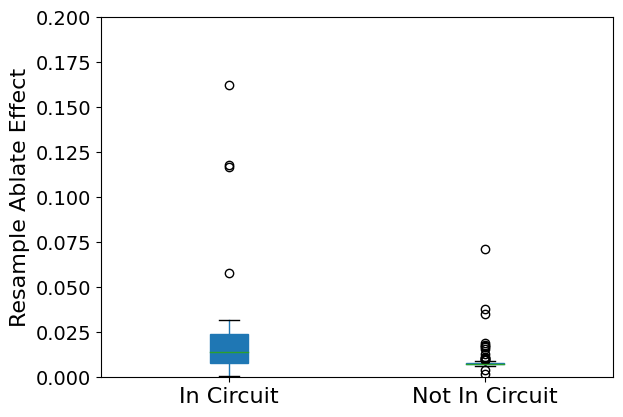

In [127]:
import matplotlib.pyplot as plt
combined_results_df.boxplot(
    by="status", 
    column="resample_ablate_effect", 
    grid=False,
    patch_artist=True
)
# reset title
plt.suptitle("")
plt.title("")

# set all font size to 14 (tick labels, title, etc.)
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 14
})
plt.ylim(0, 0.2)
plt.savefig("results/wang_ioi_effect.pdf", bbox_inches="tight")
plt.xticks([1, 2], ["In Circuit", "Not In Circuit"], rotation=0)
plt.xlabel("")
plt.ylabel("Resample Ablate Effect")
plt.savefig("results/wang_ioi_effect.pdf", bbox_inches="tight")

In [71]:
combined_results_df[combined_results_df['resample_ablate_effect'] > 0.5]

,node,status,resample_ablate_effect
12,"LLNode(name='blocks.0.mlp.hook_post', index=[:...",not_in_circuit,0.998922


In [116]:
# get mean, std, median, quantiles, and min-max range
stats = combined_results_df_without_mlp_0.groupby("status").agg(
    {"resample_ablate_effect": ["mean", "std", "median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), "min", "max"]}
).round(3)

# change the columns to have Quantiles as a single column instead of median, 25th, and 75th percentile
stats.columns = ["mean", "std", "median", "25th", "75th", "min", "max"]

stats

,mean,std,median,25th,75th,min,max
status,,,,,,,
in_circuit,0.028,0.041,0.014,0.008,0.024,0.001,0.162
not_in_circuit,0.009,0.007,0.008,0.007,0.008,0.002,0.071


In [110]:
print(stats.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & mean & std & median & 25th & 75th & min & max \\
status &  &  &  &  &  &  &  \\
\midrule
in_circuit & 0.028000 & 0.041000 & 0.014000 & 0.008000 & 0.024000 & 0.001000 & 0.162000 \\
not_in_circuit & 0.009000 & 0.007000 & 0.008000 & 0.007000 & 0.008000 & 0.002000 & 0.071000 \\
\bottomrule
\end{tabular}



In [111]:
stats.to_csv("results/wang_ioi_effect_stats.csv")

In [95]:
for row in combined_results_df.itertuples():
    node = row.node
    layer = int(node.split(".")[1])
    head = int(node[-1]) if "attn" in node else None
    row_in_circuit = (layer, head) in nodes_in_circuit
    # update the row
    combined_results_df.at[row.Index, "status"] = "in_circuit" if row_in_circuit else "not_in_circuit"

In [104]:
# get max effect
combined_results_df[combined_results_df['resample_ablate_effect'] > 0.5]

,Unnamed: 0,node,status,resample_ablate_effect,mean_ablate_effect
111,12,blocks.0.mlp.hook_post,not_in_circuit,0.999292,0.26389


In [105]:
# delete blocks.0.mlp.hook_post node from the dataframe

combined_results_df_without_mlp_0 = combined_results_df[~combined_results_df['node'].str.contains("blocks.0.mlp.hook_post")]